**Easy**

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score


MAIN_PATH = "used-car-dataset-ford-and-mercedes"

df = pd.read_csv(os.path.join(MAIN_PATH, "cclass.csv"))
numeric_heads = ["year", "mileage", "engineSize"]

x_train, x_test, y_train, y_test = train_test_split(
    df[numeric_heads],
    df["price"],
    train_size=0.8,
    random_state=42
)


model = DecisionTreeRegressor(max_depth=7)
model.fit(x_train, y_train)

test_y_pred = model.predict(x_test)
train_y_pred = model.predict(x_train)

print(
    f"train r2_score: {r2_score(train_y_pred, y_train)}\n"
    f"test  r2_score: {r2_score(test_y_pred, y_test)}"
)

train r2_score: 0.9076189265304088
test  r2_score: 0.8945996640680566


In [2]:
x_train.head(10)

,year,mileage,engineSize
2330,2018,12000,1.5
2770,2019,2499,2.0
2787,2019,12582,2.0
1833,2017,29979,2.0
650,2017,33538,2.0
1862,2018,5454,2.0
2610,2019,9000,2.0
2223,2017,27573,2.1
175,2016,21945,2.0
278,2017,27424,2.1


we've set max_depth equals 7 and our train and test predictions almost identical in terms of r2_score metric.

If we set the max_depth higher we'll get overfitting and underfitting vice versa

In [3]:
importances = model.feature_importances_
importances

array([0.14718357, 0.53776806, 0.31504837])

As we see - the "mileage" is the most important parameter

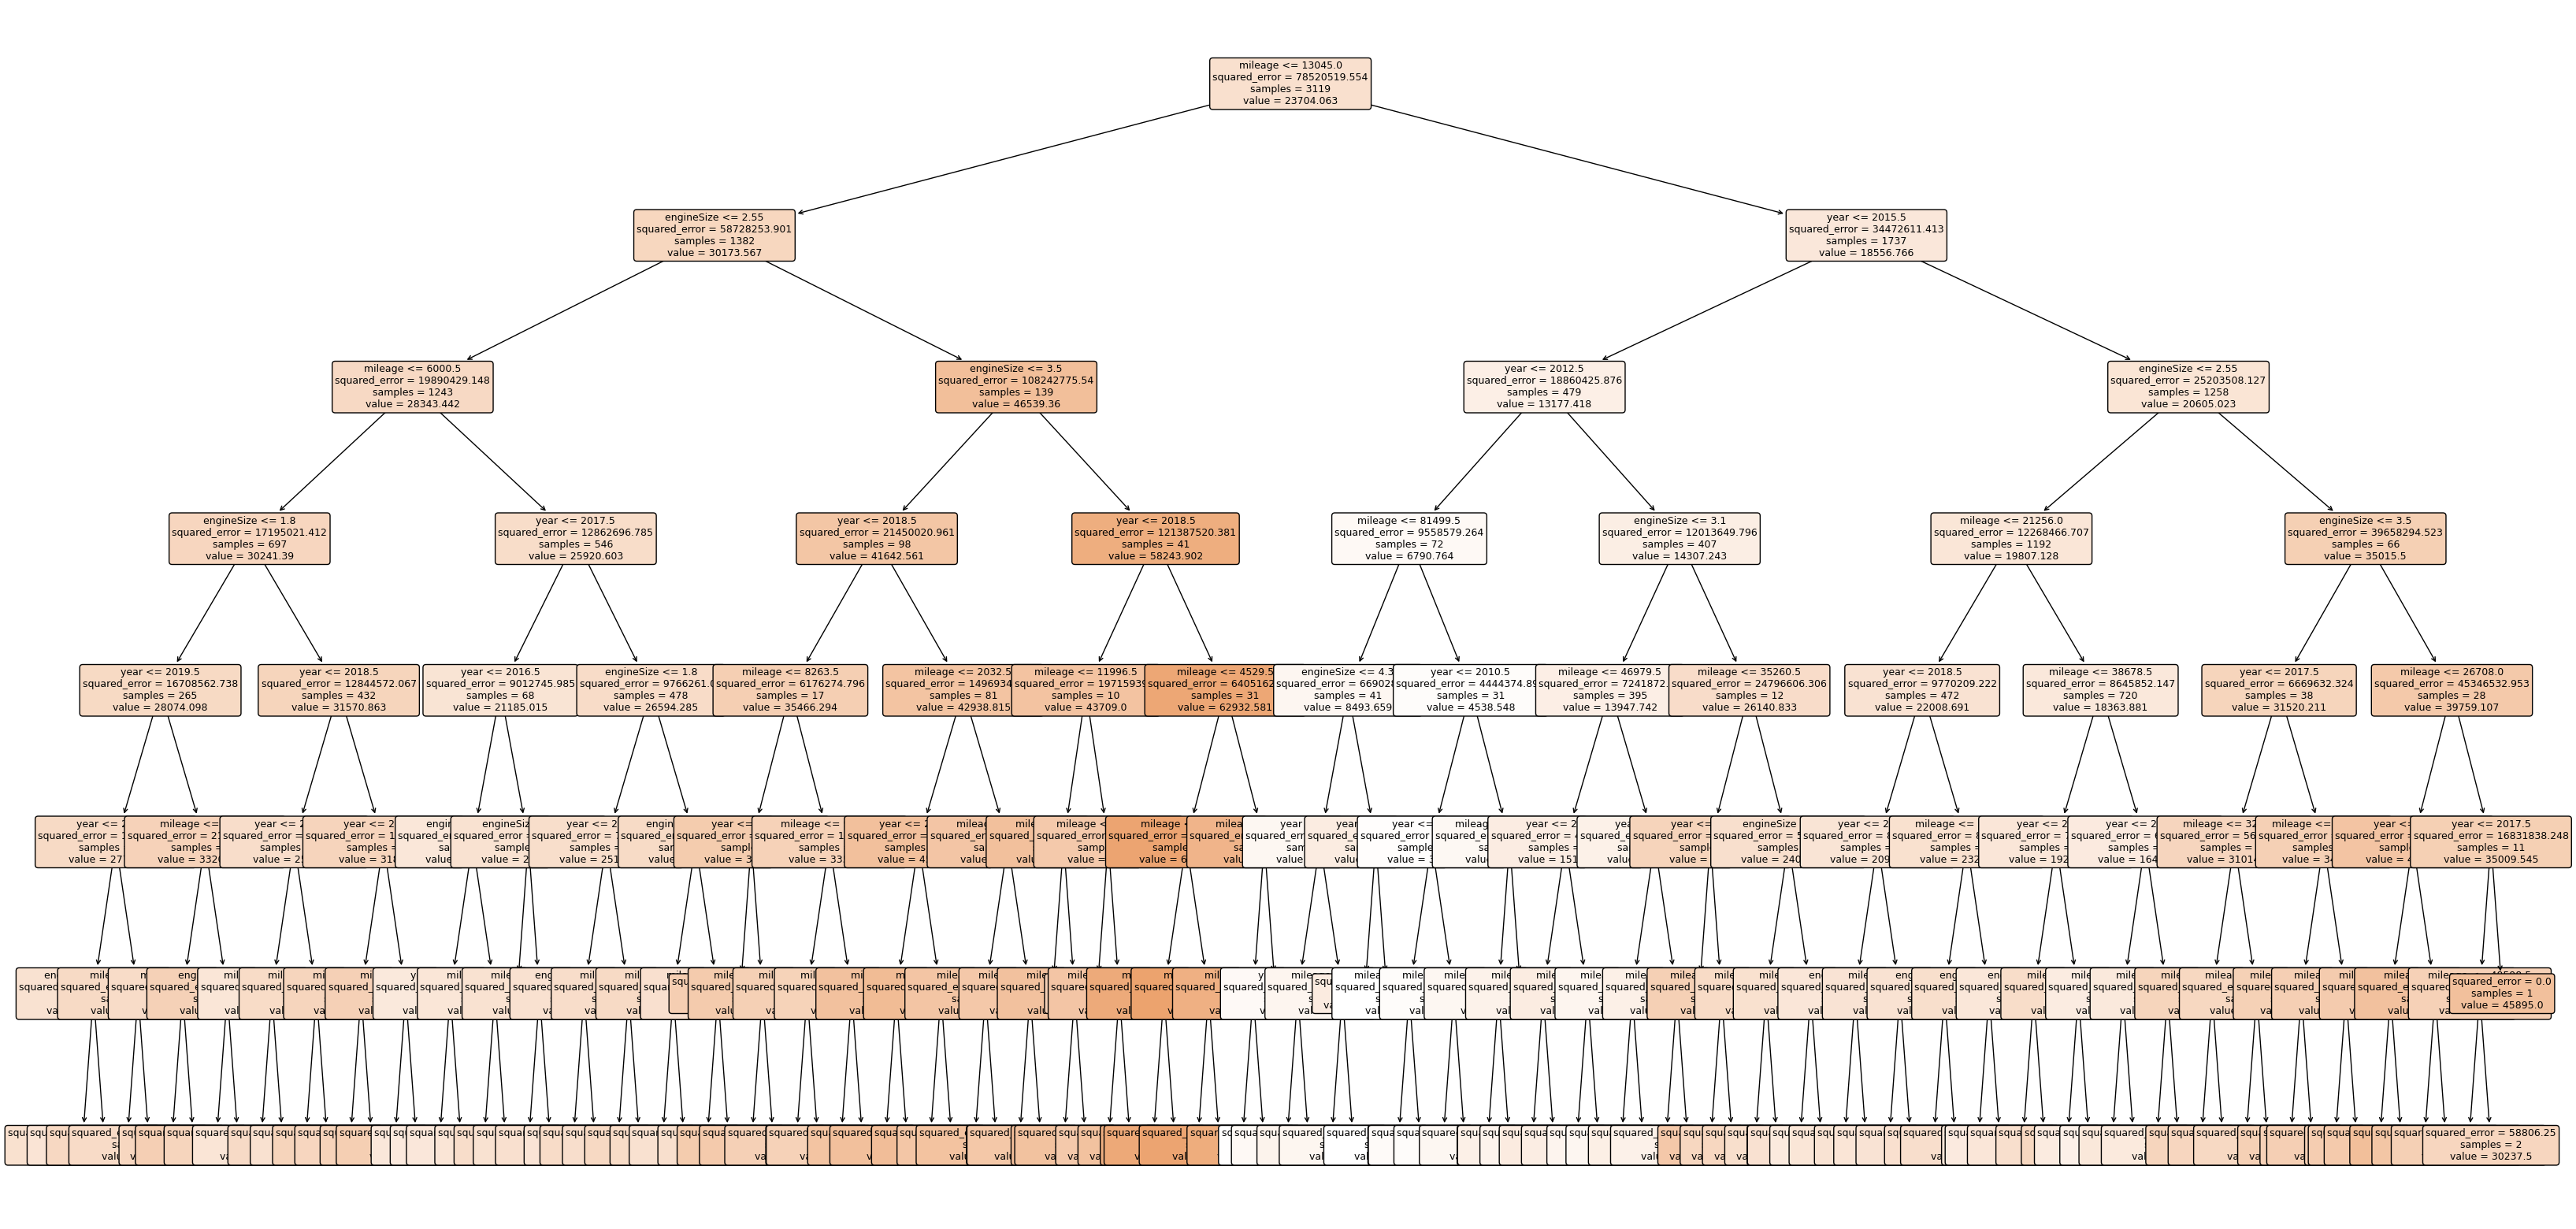

In [4]:
plt.figure(figsize=(40,20))

plot_tree(
    model,
    feature_names=numeric_heads,
    filled=True,
    fontsize=9,
    rounded=True
)

plt.show()

**Normal**

In [5]:
car_models = os.listdir(MAIN_PATH)
car_models.remove("unclean focus.csv")
car_models.remove("unclean cclass.csv")

# getting common headers
common_headers = set()
for car_model in car_models:
    df = pd.read_csv(os.path.join(MAIN_PATH, car_model))
    if not common_headers:
        common_headers = set(df.columns.values)
    else:
        common_headers &= set(df.columns.values)

# union csv files
cars_list, heads = [], list(common_headers)
for car_model in car_models:
    df = pd.read_csv(os.path.join(MAIN_PATH, car_model))
    cars_list += df[heads].values.tolist()


random.shuffle(cars_list)
cars = pd.DataFrame(cars_list, columns=heads)

In [6]:
cars.head()

,engineSize,mileage,transmission,fuelType,year,price,model
0,1.0,12603,Manual,Petrol,2018,6789,I10
1,1.8,23509,Manual,Petrol,2012,8134,Avensis
2,1.4,1326,Automatic,Petrol,2016,10498,Corsa
3,1.0,6119,Manual,Petrol,2019,6791,Viva
4,1.2,9987,Manual,Petrol,2018,8899,Ka+


As we can see, there r only 3 string columns

In [7]:
from sklearn.preprocessing import OneHotEncoder

string_categories = [
    ('transmission', list(cars['transmission'].unique())),
    ('fuelType', list(cars['transmission'].unique())),
    ('model', list(cars['model'].unique())),
]

ohe_columns = [x[0] for x in string_categories]
ohe_categories = [x[1] for x in string_categories]
enc = OneHotEncoder(sparse_output=False, categories=ohe_categories)
cars[ohe_columns] = cars[ohe_columns].astype('category')

for column_name, l in string_categories:
    cars[column_name] = cars[column_name].cat.set_categories(l)


In [8]:
from sklearn.model_selection import GridSearchCV


params = {
    "criterion": ('poisson', 'friedman_mse', 'squared_error', 'absolute_error'),
    "splitter": ("best", "random"),
    "max_depth": list(range(4, 12)),
}


search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    params,
    n_jobs=-1
)

search.fit(x_train, y_train)

In [9]:
best_params, best_score = search.best_params_, search.best_score_

print(
    f"Best paramters: {best_params}\n"
    f"Best score: {best_score}"
)

Best paramters: {'criterion': 'poisson', 'max_depth': 7, 'splitter': 'best'}
Best score: 0.8843921210045409


a model with parameters above in print section is the best among models with parameters described in "params" dictionary

**Hard**

In [10]:
import requests
import re
from bs4 import BeautifulSoup


def get_batch(merc_c):
    data = []
    for merc in merc_c:
        # converting to pounds
        price = merc.find("span", "css-46itwz e162wx9x0").find("span").text
        price = int(int("".join(str(price).split()))*0.0085)

        year = merc.find("div", "css-16kqa8y e3f4v4l2")
        if not year:
            continue
        year = year.find("span").text
        year = year.split()[-1]


        engine_size_miles_age = merc.find_all("span", "css-1l9tp44 e162wx9x0")
        engine_size = engine_size_miles_age[0].text.split()[0]

        # converting km to miles

        mileage = list(filter(lambda item: 'км' in item.text, engine_size_miles_age))
        if not mileage:
            continue
        mileage = mileage[0].text
        mileage = int(int(re.sub("[^0-9]", "", mileage))*0.621371)

        data.append([year, mileage, engine_size, price])

    return data

dataset = []

for i in range(1, 50):
    link = f"https://auto.drom.ru/mercedes-benz/c-class/page{i}"
    page = requests.get(link)
    soup = BeautifulSoup(page.content, "html.parser")
    merc_c = soup.find_all("a", class_="css-4zflqt e1huvdhj1")

    data = get_batch(merc_c)
    dataset += data

In [11]:
print(len(dataset))

new_dataset = pd.DataFrame(
    dataset,
    columns=["year", "mileage", "engineSize", "price"]
)

890


In [12]:
new_dataset.head()

,year,mileage,engineSize,price
0,2018,26097,4.0,67150
1,2019,49398,1.5,22261
2,2013,37294,1.8,15045
3,2012,106092,1.6,15198
4,2012,90098,1.8,13430


In [13]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(
    new_dataset[numeric_heads],
    new_dataset["price"],
    train_size=0.8,
    random_state=42
)


model = DecisionTreeRegressor(max_depth=7)
model.fit(x_train_c, y_train_c)

test_y_pred = model.predict(x_test_c)
train_y_pred = model.predict(x_train_c)

print(
    f"train r2_score: {r2_score(train_y_pred, y_train_c)}\n"
    f"test  r2_score: {r2_score(test_y_pred, y_test_c)}"
)

train r2_score: 0.942226306149454
test  r2_score: 0.9101973804390076


In [14]:
importances = model.feature_importances_
importances

array([0.83206832, 0.09925769, 0.06867399])

Pretty unexpected result. We've got better r2_score due to now we have much more records

In UK, the most important parameter is mileage

In Russia - year